<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/severstal_play.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image
import pickle

import time 

In [0]:
sz = (1600, 256) #size of input images
sz0 = 256
# MASKS = '/content/drive/My Drive/Kaggle/play/severstal-steel-old/train.csv'
# IMAGES = '/content/drive/My Drive/Kaggle/play/severstal-steel-old/images/train_images/'          #test or train

def enc2mask(encs, shape=(1600,256)):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

In [0]:
df_masks = pd.read_csv(MASKS)
split_df = df_masks['ImageId_ClassId'].str.split('_', n=1, expand=True)
df_masks['Image'] = split_df[0]
normal_data = []
multi = []
for image_code in tqdm(df_masks.Image.unique()):
    if df_masks.groupby(['Image']).EncodedPixels.count().loc[image_code] == 0:
        normal_data.append(image_code)
    elif df_masks.groupby(['Image']).EncodedPixels.count().loc[image_code] > 1:
        multi.append(image_code)

100%|██████████| 12568/12568 [04:14<00:00, 49.30it/s]


In [0]:
len(normal_data)

5902

In [0]:
len(multi)

427

In [0]:
df_masks = pd.read_csv(MASKS)
df_masks['id'] = [id[:-2] for id in df_masks.ImageId_ClassId]
df_masks = pd.DataFrame(df_masks.groupby('id')['EncodedPixels'].apply(list))

fnames = os.listdir(IMAGES)
n_crops = 6
offsets = [32 + sz0*i for i in range(n_crops)]

In [0]:
offsets

[32, 288, 544, 800, 1056, 1312]

In [0]:
df_masks

,EncodedPixels
id,
0002cc93b.jpg,[29102 12 29346 24 29602 24 29858 24 30114 24 ...
00031f466.jpg,"[nan, nan, nan, nan]"
000418bfc.jpg,"[nan, nan, nan, nan]"
000789191.jpg,"[nan, nan, nan, nan]"
0007a71bf.jpg,"[nan, nan, 18661 28 18863 82 19091 110 19347 1..."
...,...
fff0295e1.jpg,"[nan, nan, nan, nan]"
fff02e9c5.jpg,"[nan, nan, 207523 3 207777 9 208030 15 208283 ..."
fffe98443.jpg,"[nan, nan, 105929 5 106177 14 106424 24 106672..."


In [0]:
len(fnames)

12568

In [0]:
datadict = dict()
datadict['0'] = []
datadict['1'] = []
datadict['2'] = []
datadict['3'] = []
datadict['4'] = []
f = open('/content/drive/My Drive/Kaggle/play/severstal-steel-old/black_image.txt', 'w')
count = 0
for fname in tqdm(fnames[:160]):
    if '.jpg' not in fname:
        continue
    img0 = Image.open(os.path.join(IMAGES, fname))
    img0 = np.asarray(img0)
    if fname in normal_data:
        normal_data.remove(fname)
        r = np.random.randint(0,n_crops)
        img = img0[:, offsets[r] : offsets[r]+sz0, :]
        if img.mean() < 5 and img.std() < 5:
            f.write(fname+'\n')
            count += 1
            continue
        img = img.reshape([sz0*sz0*3])
        datadict['0'].append(img)
        continue
    elif fname in multi:
        continue
        
    mask0 = enc2mask(df_masks.loc[fname].EncodedPixels)
    
    for i in range(n_crops):
        img = img0[:, offsets[i] : offsets[i]+sz0, :]
        if img.mean() < 5 and img.std() < 5:
            f.write(fname+'\n')
            count += 1
            continue
        img = img.reshape([sz0*sz0*3])
        mask = mask0[:, offsets[i]:offsets[i]+sz0]
        lab = []
        for v in range(1,5):
            lab.append(list(mask.flat).count(v))
        if mask.max() == 0:
            datadict['0'].append(img)
        else:
            datadict[str(np.argmax(lab)+1)].append(img)
f.write(str(count))
f.close() 


# #additional
# train_dict = dict()
# test_dict = dict()
# for k,v in datadict.items():
#     num_data = len(v)
#     global_idx = np.arange(num_data)
#     np.random.shuffle(global_idx)
#     train_idx = global_idx[:int(num_data*0.7)]
#     test_idx = global_idx[int(num_data*0.7):]
#     train_dict[k] = np.array(v)[train_idx]
#     test_dict[k] = np.array(v)[test_idx]


# train = dict()
# test = dict()
# train['data'] = []
# train['label'] = []
# test['data'] = []
# test['label'] = []

# for k,v in train_dict.items():
#     for img in v:
#         train['data'].append(img)
#         train['label'].append(int(k))
# train['data'] = np.array(train['data'])
# train['label'] = np.array(train['label'])

# for k,v in test_dict.items():
#     for img in v:
#         test['data'].append(img)
#         test['label'].append(int(k))
# test['data'] = np.array(test['data'])
# test['label'] = np.array(test['label'])

# # pickling the array
# train_file = open('/content/drive/My Drive/Kaggle/severstal-steel-old/new/train_uni', 'wb')
# pickle.dump(train, train_file, protocol=pickle.HIGHEST_PROTOCOL)
# train_file.close()
# test_file = open('/content/drive/My Drive/Kaggle/severstal-steel-old/new/test_uni', 'wb')
# pickle.dump(test, test_file, protocol=pickle.HIGHEST_PROTOCOL)
# test_file.close()

# info = open('/content/drive/My Drive/Kaggle/severstal-steel-old/new/uni_info.txt', 'w')
# s = '0: '+str(len(datadict['0']))+'\t1: '+str(len(datadict['1']))+'\t2: '+str(len(datadict['2']))+'\t3: '+str(len(datadict['3']))+'\t4: '+str(len(datadict['4']))
# info.write(s)
# info.close()

# _X = np.array(train['data'])
# _Y = np.array(train['label'])

# assert _X.shape[0] == _Y.shape[0]
# datadict = dict()
# for i in range(5):
#     datadict[str(i)]=[]

# for d, l in tqdm(zip(_X, _Y)):
#     datadict[str(l)].append(d)

# for k, v in tqdm(datadict.items()):
#     fname = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/unilabel_train_'+ k
#     f = open(fname, 'wb')
#     pickle.dump(np.array(v), f, protocol=pickle.HIGHEST_PROTOCOL)
#     f.close()

# _X = np.array(test['data'])
# _Y = np.array(test['label'])

# assert _X.shape[0] == _Y.shape[0]
# datadict = dict()
# for i in range(5):
#     datadict[str(i)]=[]

# for d, l in tqdm(zip(_X, _Y)):
#     datadict[str(l)].append(d)

# for k, v in tqdm(datadict.items()):
#     fname = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/unilabel_test_'+ k
#     f = open(fname, 'wb')
#     pickle.dump(np.array(v), f, protocol=pickle.HIGHEST_PROTOCOL)
#     f.close()

# chunk = dict()
# chunk['0']=8
# chunk['3']=3

# for i in range(5):
#     fname = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/unilabel_train_'+ str(i)
#     f = open(fname, 'rb')
#     data = pickle.load(f)
#     f.close()
#     f = open('/content/drive/My Drive/Kaggle/severstal-steel-old/new/chunked_unilabel_train_'+ str(i), 'wb')
#     if i == 1 or i == 2 or i == 4:
#         print ('label ', i, 'has of length', data.shape[0])
#         pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
#         f.close()
#     else:
#         np.random.shuffle(data)
#         print ('label ', i, 'has of length', data.shape[0], 'chunk to ',\
#                data.shape[0]//chunk[str(i)]) 
#         pickle.dump(data[:int(data.shape[0]//chunk[str(i)])], f, protocol=pickle.HIGHEST_PROTOCOL)
#         f.close()

# chunk = dict()
# chunk['0']=3

# for i in range(5):
#     fname = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/unilabel_test_'+ str(i)
#     f = open(fname, 'rb')
#     data = pickle.load(f)
#     f.close()
#     f = open('/content/drive/My Drive/Kaggle/severstal-steel-old/new/chunked_unilabel_test_'+ str(i), 'wb')
#     if i != 0:
#         print ('label ', i, 'has of length', data.shape[0])
#         pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
#         f.close()
#     else:
#         np.random.shuffle(data)
#         print ('label ', i, 'has of length', data.shape[0], 'chunk to ',\
#                data.shape[0]//chunk[str(i)])
#         pickle.dump(data[:int(data.shape[0]//chunk[str(i)])], f, protocol=pickle.HIGHEST_PROTOCOL)
#         f.close()



100%|██████████| 160/160 [03:56<00:00,  1.39s/it]


In [0]:
len(datadict['4'])

14

In [0]:
train_dict = dict()
test_dict = dict()
for k,v in datadict.items():
    num_data = len(v)
    global_idx = np.arange(num_data)
    np.random.shuffle(global_idx)
    train_idx = global_idx[:int(num_data*0.7)]
    test_idx = global_idx[int(num_data*0.7):]
    train_dict[k] = np.array(v)[train_idx]
    test_dict[k] = np.array(v)[test_idx]

In [0]:
len(v)

14

In [0]:
train_idx

array([ 0,  3,  6, 11,  8,  9, 13, 10,  5])

In [0]:
len(train_dict['4'])

9

In [0]:
train_dict['4']

array([[101, 101, 101, ..., 208, 208, 208],
       [105, 105, 105, ..., 209, 209, 209],
       [ 54,  54,  54, ...,  57,  57,  57],
       ...,
       [ 83,  83,  83, ...,  95,  95,  95],
       [ 63,  63,  63, ..., 118, 118, 118],
       [ 48,  48,  48, ...,  86,  86,  86]], dtype=uint8)

In [0]:
train = dict()
test = dict()
train['data'] = []
train['label'] = []
test['data'] = []
test['label'] = []

for k,v in train_dict.items():
    for img in v:
        train['data'].append(img)
        train['label'].append(int(k))
train['data'] = np.array(train['data'])
train['label'] = np.array(train['label'])

In [0]:
len(train['data'])

343

In [0]:
for k,v in test_dict.items():
    for img in v:
        test['data'].append(img)
        test['label'].append(int(k))
test['data'] = np.array(test['data'])
test['label'] = np.array(test['label'])

In [0]:
# pickling the array
train_file = open('/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/train_uni', 'wb')
pickle.dump(train, train_file, protocol=pickle.HIGHEST_PROTOCOL)
train_file.close()
test_file = open('/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/test_uni', 'wb')
pickle.dump(test, test_file, protocol=pickle.HIGHEST_PROTOCOL)
test_file.close()

In [0]:
info = open('/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/uni_info.txt', 'w')
s = '0: '+str(len(datadict['0']))+'\t1: '+str(len(datadict['1']))+'\t2: '+str(len(datadict['2']))+'\t3: '+str(len(datadict['3']))+'\t4: '+str(len(datadict['4']))
info.write(s)
info.close()

In [0]:
_X = np.array(train['data'])
_Y = np.array(train['label'])

assert _X.shape[0] == _Y.shape[0]
datadict = dict()
for i in range(5):
    datadict[str(i)]=[]

for d, l in tqdm(zip(_X, _Y)):
    datadict[str(l)].append(d)

for k, v in tqdm(datadict.items()):
    fname = '/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/unilabel_train_'+ k
    f = open(fname, 'wb')
    pickle.dump(np.array(v), f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

343it [00:00, 114880.32it/s]
100%|██████████| 5/5 [00:00<00:00,  9.85it/s]


In [0]:
_X = np.array(test['data'])
_Y = np.array(test['label'])

assert _X.shape[0] == _Y.shape[0]
datadict = dict()
for i in range(5):
    datadict[str(i)]=[]

for d, l in tqdm(zip(_X, _Y)):
    datadict[str(l)].append(d)

for k, v in tqdm(datadict.items()):
    fname = '/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/unilabel_test_'+ k
    f = open(fname, 'wb')
    pickle.dump(np.array(v), f, protocol=pickle.HIGHEST_PROTOCOL)
    f.close()

150it [00:00, 108305.32it/s]
100%|██████████| 5/5 [00:00<00:00, 34.67it/s]


In [0]:
chunk = dict()
chunk['0']=8
chunk['3']=3

for i in range(5):
    fname = '/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/unilabel_train_'+ str(i)
    f = open(fname, 'rb')
    data = pickle.load(f)
    f.close()
    f = open('/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/chunked_unilabel_train_'+ str(i), 'wb')
    if i == 1 or i == 2 or i == 4:
        print ('label ', i, 'has of length', data.shape[0])
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()
    else:
        np.random.shuffle(data)
        print ('label ', i, 'has of length', data.shape[0], 'chunk to ',\
               data.shape[0]//chunk[str(i)]) 
        pickle.dump(data[:int(data.shape[0]//chunk[str(i)])], f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()

label  0 has of length 201 chunk to  25
label  1 has of length 17
label  2 has of length 2
label  3 has of length 114 chunk to  38
label  4 has of length 9


In [0]:
chunk = dict()
chunk['0']=3

for i in range(5):
    fname = '/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/unilabel_test_'+ str(i)
    f = open(fname, 'rb')
    data = pickle.load(f)
    f.close()
    f = open('/content/drive/My Drive/Kaggle/play/severstal-steel-old/new/chunked_unilabel_test_'+ str(i), 'wb')
    if i != 0:
        print ('label ', i, 'has of length', data.shape[0])
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()
    else:
        np.random.shuffle(data)
        print ('label ', i, 'has of length', data.shape[0], 'chunk to ',\
               data.shape[0]//chunk[str(i)])
        pickle.dump(data[:int(data.shape[0]//chunk[str(i)])], f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()

label  0 has of length 87 chunk to  29
label  1 has of length 8
label  2 has of length 1
label  3 has of length 49
label  4 has of length 5


Play

In [0]:
#play

file_name = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/train_uni'
f = open(file_name , 'rb')
pickle_data = pickle.load(f)
f.close()

In [0]:
print(type(pickle_data))

<class 'dict'>


In [0]:
len(pickle_data['data'])

26839

In [0]:
pickle_data[0][:30]

array([59, 59, 59, 66, 66, 66, 62, 62, 62, 58, 58, 58, 64, 64, 64, 63, 63,
       63, 60, 60, 60, 64, 64, 64, 69, 69, 69, 63, 63, 63], dtype=uint8)

In [0]:
rs = pickle_data['data'][7].reshape(256,256,3)

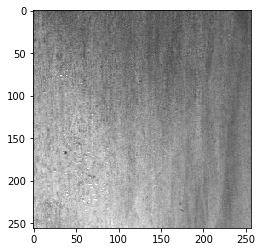

In [0]:
from matplotlib import pyplot as plt

plt.imshow(rs)

In [0]:
X = np.array(pickle_data['data'])
Y = np.array(pickle_data['label'])

In [0]:
import keras
from keras.applications import ResNet101V2

base_model = ResNet101V2(weights= 'imagenet', include_top=False, input_shape= (256,256,3))













171319296/171317808 [==============================] - 2s 0us/step


In [0]:
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
num_classes = 5

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x=Dense(512, activation='relu')(x) 
preds = Dense(num_classes, activation= 'softmax')(x)

model = Model(inputs = base_model.input, outputs = preds)

In [0]:
from keras.optimizers import SGD
sgd = SGD()

model.compile(optimizer= sgd, loss='categorical_crossentropy', metrics=['acc'])

In [0]:
model.fit(X, Y)

ValueError: ignored

In [0]:
# assert X.shape[0] == Y.shape[0]
# datadict = dict()
# for i in range(5):
#     datadict[str(i)]=[]

# for data, label in tqdm(zip(X,Y)):
#   datadict[str(label)].append(data)

# plt.savefig('/content/drive/My Drive/Kaggle/severstal-steel-old/saved_images/')

In [0]:
file_name = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/unilabel_train_0'
f = open(file_name, 'rb')
train_0 = pickle.load(f)
f.close()

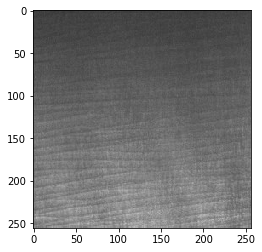

In [0]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# a = train_0[0].reshape(256,256,3)

# new_img = Image.fromarray(a , 'RGB')
# new_img.save('/content/drive/My Drive/Kaggle/severstal-steel-old/saved_images/new_image.png')
# plt.imshow(a)

In [0]:
load_img = mpimg.imread("/content/drive/My Drive/Kaggle/severstal-steel-old/saved_images/new_image.png")
plt.imshow(load_img)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for label in tqdm(range(5)):
  print(f'\n [INFO]... Loading label {str(label)}')
  file_name = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/unilabel_train_'+str(label)
  f = open(file_name, 'rb')
  train_pickle = pickle.load(f)
  f.close()
  
  print(f'\n No. of images found : {len(train_pickle)}')

  for i in tqdm(range(len(train_pickle))):   
    rs_img = train_pickle[i].reshape(256,256,3)
    array_img = Image.fromarray(rs_img, 'RGB')
    array_img.save('/content/drive/My Drive/Kaggle/severstal-steel-old/saved_images/train/'+str(label)+'/'+str(i+1)+'.png')

  

  0%|          | 0/5 [00:00<?, ?it/s]


 [INFO]... Loading label 0



  0%|          | 0/16620 [00:00<?, ?it/s]


 No. of images found : 16620



 20%|██        | 1/5 [10:44<42:58, 644.58s/it]


 [INFO]... Loading label 1



  0%|          | 0/935 [00:00<?, ?it/s]


 No. of images found : 935



 40%|████      | 2/5 [11:16<23:02, 460.85s/it]


 [INFO]... Loading label 2



  0%|          | 0/147 [00:00<?, ?it/s]


 No. of images found : 147



 60%|██████    | 3/5 [11:21<10:48, 324.16s/it]


 [INFO]... Loading label 3



  0%|          | 0/8166 [00:00<?, ?it/s]


 No. of images found : 8166



 80%|████████  | 4/5 [16:23<05:17, 317.49s/it]


 [INFO]... Loading label 4



  0%|          | 0/971 [00:00<?, ?it/s]


 No. of images found : 971



100%|██████████| 5/5 [17:00<00:00, 233.27s/it]


In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for label in tqdm(range(5)):
  print(f'\n [INFO]... Loading label {str(label)}')
  file_name = '/content/drive/My Drive/Kaggle/severstal-steel-old/new/unilabel_test_'+str(label)
  f = open(file_name, 'rb')
  test_pickle = pickle.load(f)
  f.close()
  
  print(f'\n No. of images found : {len(test_pickle)}')

  for i in tqdm(range(len(test_pickle))):   
    rs_img = test_pickle[i].reshape(256,256,3)
    array_img = Image.fromarray(rs_img, 'RGB')
    array_img.save('/content/drive/My Drive/Kaggle/severstal-steel-old/saved_images/test/'+str(label)+'/'+str(i+1)+'.png')

  

  0%|          | 0/5 [00:00<?, ?it/s]


 [INFO]... Loading label 0



  0%|          | 0/7124 [00:00<?, ?it/s]


 No. of images found : 7124



 20%|██        | 1/5 [03:58<15:54, 238.70s/it]


 [INFO]... Loading label 1



  1%|          | 3/401 [00:00<00:15, 26.41it/s]


 No. of images found : 401



 40%|████      | 2/5 [04:12<08:34, 171.34s/it]


 [INFO]... Loading label 2



  8%|▊         | 5/63 [00:00<00:01, 48.58it/s]


 No. of images found : 63



 60%|██████    | 3/5 [04:15<04:01, 120.69s/it]


 [INFO]... Loading label 3



  0%|          | 4/3500 [00:00<01:46, 32.76it/s]


 No. of images found : 3500



 80%|████████  | 4/5 [06:14<02:00, 120.35s/it]


 [INFO]... Loading label 4



  1%|          | 4/417 [00:00<00:11, 36.77it/s]


 No. of images found : 417



100%|██████████| 5/5 [06:30<00:00, 88.82s/it] 
